In [121]:
import os
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy 

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

ModuleNotFoundError: No module named 'catboost'

In [34]:
# Читаем редактированный файл с выборкой
df = pd.read_pickle("../data/clean_data.pkl")

In [35]:
df.head(5)

c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,car_mileage,price_diff
0,2014,3.349609,5.589844,27000,Petrol,Petrol,Petrol,0,mid,0.599231
1,2013,4.750000,9.539062,43000,Diesel,Diesel,Diesel,0,mid,0.497952
2,2017,7.250000,9.851562,6900,Petrol,Petrol,Petrol,0,low,0.735924
3,2011,2.849609,4.148438,5200,Petrol,Petrol,Petrol,0,low,0.686911
4,2014,4.601562,6.871094,42450,Diesel,Diesel,Diesel,0,mid,0.669699


In [36]:
# Переименовываем столбец 'Selling_Price' в 'target'
df = df.rename(columns={'Selling_Price': 'target'})

In [37]:
df.head(5)

c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Year,target,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,car_mileage,price_diff
0,2014,3.349609,5.589844,27000,Petrol,Petrol,Petrol,0,mid,0.599231
1,2013,4.750000,9.539062,43000,Diesel,Diesel,Diesel,0,mid,0.497952
2,2017,7.250000,9.851562,6900,Petrol,Petrol,Petrol,0,low,0.735924
3,2011,2.849609,4.148438,5200,Petrol,Petrol,Petrol,0,low,0.686911
4,2014,4.601562,6.871094,42450,Diesel,Diesel,Diesel,0,mid,0.669699


In [39]:
# Разбиение выборки на тестовую и обучающую
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=1)

In [40]:
# Категориальные признаки
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['Year', 'Fuel_Type', 'Selling_type', 'Transmission', 'car_mileage']

In [41]:
# Числовые признаки
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['Present_Price', 'Driven_kms', 'Owner', 'price_diff']

In [42]:
# Определяем скейлер, энкодер и регрессор
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) # unknown_value нужно выбирать с умом
regressor = RandomForestRegressor()

In [43]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [44]:
# Создаем пайплайн и обучаем модель
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

2025/01/25 18:29:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000016CDFD898C0>: Failed to establish a new connection: [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение'))


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Year', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission',
                                                   'car_mileage'])])),
                ('model', RandomForestRegressor())])

In [45]:
# Расчёт метрик
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.44804036458333324,
 'mape': 0.09397712549885008,
 'mse': 3.747447754091381}

In [46]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [47]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "car_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "car_model_rf"

In [48]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [49]:
# Будем логировать requirements и артефакт - текстовый файл
req_file = '../requirements.txt'
art = '../comment.txt'

In [50]:
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
#params_dict = {'n_estimators': 10, 'max_depth': 10}
params_dict = pipeline.get_params()

In [51]:
# Когда создаем новый эксперимент, то: 
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'car_model_rf' already exists. Creating a new version of this model...
2025/01/25 18:30:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_model_rf, version 4
Created version '4' of model 'car_model_rf'.


🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/a0335e689d0d4b348a1b9ad575519844
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [52]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
#mlflow.delete_experiment(experiment_id)

In [53]:
mlflow.search_runs(
    #experiment_ids=[experiment_id],
    experiment_names=[EXPERIMENT_NAME],
    # filter_string='status = "FAILED"'
    #filter_string='metrics.mae > 1'
    
)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mae,metrics.mape,metrics.mse,metrics.training_score,...,params.model__oob_score,params.preprocessor__cat__max_categories,params.preprocessor__num__copy,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.log-model.history,tags.mlflow.runName,tags.estimator_class,tags.estimator_name
0,a0335e689d0d4b348a1b9ad575519844,1,FINISHED,mlflow-artifacts:/1/a0335e689d0d4b348a1b9ad575...,2025-01-25 15:30:22.840000+00:00,2025-01-25 15:30:24.350000+00:00,0.448040,0.093977,3.747448,NaN,...,False,None,True,LOCAL,C:\Users\shepe\AppData\Roaming\Python\Python31...,shepe,"[{""run_id"": ""a0335e689d0d4b348a1b9ad575519844""...",baseline model,None,None
1,7b4e1aaacb4c45698767e7d51ab86420,1,FINISHED,mlflow-artifacts:/1/7b4e1aaacb4c45698767e7d51a...,2025-01-25 15:19:39.872000+00:00,2025-01-25 15:19:41.068000+00:00,0.446589,0.119194,2.178341,NaN,...,False,None,True,LOCAL,C:\Users\shepe\AppData\Roaming\Python\Python31...,shepe,"[{""run_id"": ""7b4e1aaacb4c45698767e7d51ab86420""...",smaller_model,None,None
2,a98512e72a2a47f495f0b99d70eed7af,1,FINISHED,mlflow-artifacts:/1/a98512e72a2a47f495f0b99d70...,2025-01-25 15:18:20.544000+00:00,2025-01-25 15:18:27.457000+00:00,NaN,NaN,NaN,0.988368,...,False,None,True,LOCAL,C:\Users\shepe\AppData\Roaming\Python\Python31...,shepe,"[{""run_id"": ""a98512e72a2a47f495f0b99d70eed7af""...",auto,sklearn.pipeline.Pipeline,Pipeline
3,0f922d3d0e904301a3a18671c0322b6b,1,FINISHED,mlflow-artifacts:/1/0f922d3d0e904301a3a18671c0...,2025-01-25 15:12:43.328000+00:00,2025-01-25 15:12:44.401000+00:00,0.437091,0.091510,3.429280,NaN,...,False,None,True,LOCAL,C:\Users\shepe\AppData\Roaming\Python\Python31...,shepe,"[{""run_id"": ""0f922d3d0e904301a3a18671c0322b6b""...",baseline model,None,None
4,83fdcdf275ba404b84784419873664c1,1,FAILED,mlflow-artifacts:/1/83fdcdf275ba404b8478441987...,2025-01-25 15:11:33.687000+00:00,2025-01-25 15:11:37.703000+00:00,0.437091,0.091510,3.429280,NaN,...,None,None,None,LOCAL,C:\Users\shepe\AppData\Roaming\Python\Python31...,shepe,"[{""run_id"": ""83fdcdf275ba404b84784419873664c1""...",baseline model,None,None


In [23]:
#mlflow.delete_run('74d2a7a40c07413c9cf65df841164356')

In [54]:
mlflow.sklearn.autolog()

with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
    pipeline.fit(X_train, y_train)

2025/01/25 18:30:39 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/01/25 18:30:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whene

🏃 View run auto at: http://127.0.0.1:5000/#/experiments/1/runs/253de2a7c30142ef8b7ca2936ee89fad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [55]:
# Используем Случайный Лес
regressor2 = RandomForestRegressor(n_estimators=10, max_depth=6)

In [56]:
# Создаём пайплайн и обучаем модель
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor2)])

pipeline.fit(X_train, y_train)

2025/01/25 18:32:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd16a53d5a00d431aa976e34e80e31e10', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 18:32:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Inte

🏃 View run ambitious-cub-855 at: http://127.0.0.1:5000/#/experiments/0/runs/d16a53d5a00d431aa976e34e80e31e10
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Year', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission',
                                                   'car_mileage'])])),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=10))])

In [57]:
# Расчёт метрик
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

2025/01/25 18:32:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


{'mae': 0.5446160003157189,
 'mape': 0.11399581546607539,
 'mse': 4.150293271301447}

In [58]:
# Записываем результаты в mlflow
RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2025/01/25 18:32:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Registered model 'car_model_rf' already exists. Creating a new version of this model...
2025/01/25 18:32:45 INFO mlflow.store.mo

🏃 View run smaller_model at: http://127.0.0.1:5000/#/experiments/1/runs/f0735c4c2c3a40199da3c67470eec97e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [59]:
class MlExperiment():
    def __init__(self, RUN_NAME, EXPERIMENT_NAME, preprocessor, regressor) -> None:
        self.RUN_NAME = RUN_NAME
        self.EXPERIMENT_NAME = EXPERIMENT_NAME
        self.pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

    def model_fit(self, X_train, y_train):
        self.pipeline.fit(X_train, y_train)  
          
    def model_predict(self, X_test, y_test):
        predictions = self.pipeline.predict(X_test) 
        self.metrics = {}
        self.metrics["mae"] = mean_absolute_error(y_test, predictions)   
        self.metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
        self.metrics["mse"] = mean_squared_error(y_test, predictions)


    def start_run(self, signature, input_example, art):
        experiment_id = mlflow.get_experiment_by_name(self.EXPERIMENT_NAME).experiment_id
        with mlflow.start_run(run_name=self.RUN_NAME, experiment_id=experiment_id) as run:
            # получаем уникальный идентификатор запуска эксперимента
            run_id = run.info.run_id 
            mlflow.sklearn.log_model(self.pipeline, 
                                    artifact_path="models",
                                    signature=signature,
                                    input_example=input_example,
                                    pip_requirements=req_file,
                                    registered_model_name = REGISTRY_MODEL_NAME
                                    )
            mlflow.log_metrics(self.metrics)
            mlflow.log_artifact(art)
            mlflow.log_params(self.pipeline.get_params())

        run = mlflow.get_run(run_id) 
        assert (run.info.status =='FINISHED')

***Feature engineering***

In [60]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler

In [61]:
X_train_sklearn = X_train.copy()

In [62]:
# Модель для генерации признаков
pf = PolynomialFeatures(degree=2)

In [63]:
X_train_sklearn

c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Year,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,car_mileage,price_diff
5,2018,9.828125,2071,Diesel,Diesel,Diesel,0,low,0.941176
104,2017,1.469727,4100,Petrol,Petrol,Petrol,0,low,0.918272
39,2003,7.980469,62000,Petrol,Petrol,Petrol,0,high,0.281938
97,2017,18.640625,8700,Petrol,Petrol,Petrol,0,low,0.911987
68,2011,13.742188,88000,Petrol,Petrol,Petrol,0,high,0.316657
...,...,...,...,...,...,...,...,...,...
205,2016,5.699219,3493,Petrol,Petrol,Petrol,1,low,0.921179
257,2015,13.601562,40324,Petrol,Petrol,Petrol,0,mid,0.624928
73,2011,5.710938,43000,Petrol,Petrol,Petrol,0,mid,0.464090
237,2015,13.601562,68000,Diesel,Diesel,Diesel,0,high,0.827111


In [64]:
pf.fit_transform(X_train_sklearn[['Present_Price', 'Driven_kms']])

array([[1.00000000e+00, 9.82812500e+00, 2.07100000e+03, 9.65920410e+01,
        2.03540469e+04, 4.28904100e+06],
       [1.00000000e+00, 1.46972656e+00, 4.10000000e+03, 2.16009617e+00,
        6.02587891e+03, 1.68100000e+07],
       [1.00000000e+00, 7.98046875e+00, 6.20000000e+04, 6.36878815e+01,
        4.94789062e+05, 3.84400000e+09],
       ...,
       [1.00000000e+00, 5.71093750e+00, 4.30000000e+04, 3.26148071e+01,
        2.45570312e+05, 1.84900000e+09],
       [1.00000000e+00, 1.36015625e+01, 6.80000000e+04, 1.85002502e+02,
        9.24906250e+05, 4.62400000e+09],
       [1.00000000e+00, 3.75976562e+00, 1.00790000e+04, 1.41358376e+01,
        3.78946777e+04, 1.01586241e+08]])

In [65]:
sp = SplineTransformer(n_knots=3, degree=3)

In [66]:
sp.fit_transform(X_train_sklearn[['Driven_kms']])

array([[1.63541264e-01, 6.66627223e-01, 1.69831471e-01, 4.14821076e-08,
        0.00000000e+00],
       [1.59562848e-01, 6.66460389e-01, 1.73976264e-01, 4.99159983e-07,
        0.00000000e+00],
       [7.13735361e-02, 6.13495296e-01, 3.12642554e-01, 2.48861438e-03,
        0.00000000e+00],
       ...,
       [9.52392302e-02, 6.40172664e-01, 2.63766811e-01, 8.21294755e-04,
        0.00000000e+00],
       [6.47641798e-02, 6.03491731e-01, 3.28453728e-01, 3.29036122e-03,
        0.00000000e+00],
       [1.48215614e-01, 6.65223821e-01, 1.86551161e-01, 9.40357037e-06,
        0.00000000e+00]])

In [67]:
qt = QuantileTransformer()

In [68]:
qt.fit_transform(X_train_sklearn[['Driven_kms']])

c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


array([[0.03139013],
       [0.08071749],
       [0.88116592],
       [0.15470852],
       [0.95067265],
       [0.88116592],
       [0.8206278 ],
       [0.75336323],
       [0.76681614],
       [0.0044843 ],
       [0.18834081],
       [0.49103139],
       [0.23766816],
       [0.73542601],
       [0.42376682],
       [0.93721973],
       [0.37668161],
       [0.86547085],
       [0.25560538],
       [0.        ],
       [0.52914798],
       [0.10313901],
       [0.48430493],
       [0.83856502],
       [0.38565022],
       [0.17040359],
       [0.16143498],
       [0.2735426 ],
       [0.31390135],
       [0.38565022],
       [0.02242152],
       [0.34529148],
       [0.82959641],
       [0.49103139],
       [0.31390135],
       [0.61883408],
       [0.12556054],
       [0.64573991],
       [0.69730942],
       [0.19282511],
       [0.22869955],
       [0.60986547],
       [0.50672646],
       [0.07174888],
       [0.49775785],
       [0.69730942],
       [0.93049327],
       [0.511

In [69]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [70]:
# Значения преобразованных признаков нужно отскейлить, поэтому создаем pipeline из двух шагов - преобразование и скейлинг
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [71]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,num_features),
        ('poly', pf_pipeline, ['Present_Price', 'Driven_kms']), # В преобразования добавляем созданный ранее pipeline
        ('spline', sp, ['Driven_kms'])
    ],
    remainder='drop',
    ) # Удаляем столбцы, которые не затронуты преобразования

In [72]:
X_train_sklearn[['Present_Price', 'Driven_kms']] = X_train_sklearn[['Present_Price', 'Driven_kms']].astype('float64')
X_train_sklearn[['Present_Price', 'Driven_kms']] = X_train_sklearn[['Present_Price', 'Driven_kms']].astype('float64')

In [73]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_sklearn)
X_train_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(
2025/01/25 18:37:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '15c773220c5e4f3ca29962c225d0b340', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 18:37:56 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/01/25 18:37:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run fortunate-auk-957 at: http://127.0.0.1:5000/#/experiments/0/runs/15c773220c5e4f3ca29962c225d0b340
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [74]:
# Удобно использовать для отображения всех строк\столбцов в DataFrame
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_sklearn)

,num__Present_Price,num__Driven_kms,num__Owner,num__price_diff,cat__Year,cat__Fuel_Type,cat__Selling_type,cat__Transmission,cat__car_mileage,quantile__Present_Price,quantile__Driven_kms,quantile__Owner,quantile__price_diff,poly__1,poly__Present_Price,poly__Driven_kms,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_0,spline__Driven_kms_sp_1,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3,spline__Driven_kms_sp_4
0,0.340183,-0.822864,-0.181157,1.438496,15.0,1.0,1.0,1.0,1.0,0.735426,0.031390,0.0,0.959641,0.0,0.340183,-0.822864,-0.034741,-0.573203,-0.191013,0.163541,0.666627,0.169831,4.148211e-08,0.0
1,-0.877857,-0.775944,-0.181157,1.327707,14.0,2.0,2.0,2.0,1.0,0.251121,0.080717,0.0,0.905830,0.0,-0.877857,-0.775944,-0.527827,-0.598959,-0.190285,0.159563,0.666460,0.173976,4.991600e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.890072,0.701737,-0.181157,0.886751,12.0,1.0,1.0,1.0,0.0,0.852018,0.901345,0.0,0.782511,0.0,0.890072,0.701737,0.426902,1.052774,0.077727,0.064764,0.603492,0.328454,3.290361e-03,0.0
223,-0.544137,-0.637680,-0.181157,0.745562,13.0,2.0,2.0,2.0,2.0,0.331839,0.174888,0.0,0.735426,0.0,-0.544137,-0.637680,-0.465294,-0.541673,-0.185353,0.148216,0.665224,0.186551,9.403570e-06,0.0


In [75]:
new = MlExperiment('fe_sklearn', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
new.model_fit(X_train, y_train)
new.model_predict(X_test, y_test)
new.pipeline

2025/01/25 18:38:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '56c3c3394f564b28a0a33a8e5cfbe10f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 18:38:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Inte

🏃 View run bedecked-croc-790 at: http://127.0.0.1:5000/#/experiments/0/runs/56c3c3394f564b28a0a33a8e5cfbe10f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Year', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission',
                                                   'car_mileage']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('model', RandomForestRegressor())])

In [76]:
new.metrics

{'mae': 0.4822611328125, 'mape': 0.09446738238322583, 'mse': 3.847666328015922}

In [77]:
new.start_run(signature, input_example, art)

2025/01/25 18:39:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Registered model 'car_model_rf' already exists. Creating a new version of this model...
2025/01/25 18:39:33 INFO mlflow.store.mo

🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/517db859045c466cac6552d1e0615e8c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


***FEATURE SELECTION***

Используем sklearn признаки

In [78]:
from sklearn.feature_selection import RFE
X_train_sklearn

,num__Present_Price,num__Driven_kms,num__Owner,num__price_diff,cat__Year,cat__Fuel_Type,cat__Selling_type,cat__Transmission,cat__car_mileage,quantile__Present_Price,...,poly__Present_Price,poly__Driven_kms,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_0,spline__Driven_kms_sp_1,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3,spline__Driven_kms_sp_4
0,0.340183,-0.822864,-0.181157,1.438496,15.0,1.0,1.0,1.0,1.0,0.735426,...,0.340183,-0.822864,-0.034741,-0.573203,-0.191013,0.163541,0.666627,0.169831,4.148211e-08,0.0
1,-0.877857,-0.775944,-0.181157,1.327707,14.0,2.0,2.0,2.0,1.0,0.251121,...,-0.877857,-0.775944,-0.527827,-0.598959,-0.190285,0.159563,0.666460,0.173976,4.991600e-07,0.0
2,0.070931,0.562988,-0.181157,-1.750297,0.0,2.0,2.0,2.0,0.0,0.618834,...,0.070931,0.562988,-0.206554,0.279617,0.032352,0.071374,0.613495,0.312643,2.488614e-03,0.0
3,1.624397,-0.669569,-0.181157,1.297302,14.0,2.0,2.0,2.0,1.0,0.937220,...,1.624397,-0.669569,1.275257,-0.318276,-0.186859,0.150783,0.665606,0.183604,5.898938e-06,0.0
4,0.910565,1.164235,-0.181157,-1.582359,8.0,2.0,2.0,2.0,0.0,0.881166,...,0.910565,1.164235,0.446981,1.564008,0.259225,0.045697,0.565423,0.381713,7.167314e-03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,-0.261508,-0.789980,3.507866,1.341766,13.0,2.0,2.0,2.0,1.0,0.426009,...,-0.261508,-0.789980,-0.369503,-0.574006,-0.190553,0.160746,0.666524,0.172730,2.868484e-07,0.0
220,0.890072,0.061733,-0.181157,-0.091225,12.0,2.0,2.0,2.0,2.0,0.852018,...,0.890072,0.061733,0.426902,0.376110,-0.096673,0.098976,0.643268,0.257080,6.757202e-04,0.0
221,-0.259800,0.123615,-0.181157,-0.869212,8.0,2.0,2.0,2.0,2.0,0.443946,...,-0.259800,0.123615,-0.368805,-0.168366,-0.083702,0.095239,0.640173,0.263767,8.212948e-04,0.0
222,0.890072,0.701737,-0.181157,0.886751,12.0,1.0,1.0,1.0,0.0,0.852018,...,0.890072,0.701737,0.426902,1.052774,0.077727,0.064764,0.603492,0.328454,3.290361e-03,0.0


In [79]:
rfe_skl_selector = RFE(estimator=regressor, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_sklearn,y_train)

2025/01/25 18:40:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f174e945c8614d1587ccc9a2306b24a3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run orderly-bass-991 at: http://127.0.0.1:5000/#/experiments/0/runs/f174e945c8614d1587ccc9a2306b24a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


2025/01/25 18:40:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4b261a99a56d4f739872235878615ebf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run colorful-shad-59 at: http://127.0.0.1:5000/#/experiments/0/runs/4b261a99a56d4f739872235878615ebf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


2025/01/25 18:40:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '92d382b563904f2bb6c9fbe8e370f9bf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run vaunted-goose-710 at: http://127.0.0.1:5000/#/experiments/0/runs/92d382b563904f2bb6c9fbe8e370f9bf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


2025/01/25 18:41:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b0e64ca8df354573823a341bf397297d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run melodic-bear-961 at: http://127.0.0.1:5000/#/experiments/0/runs/b0e64ca8df354573823a341bf397297d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [80]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

,num__Present_Price,num__Driven_kms,num__price_diff,cat__Year,quantile__Present_Price,quantile__Driven_kms,quantile__price_diff,poly__Present_Price,poly__Driven_kms,poly__Present_Price^2,spline__Driven_kms_sp_0,spline__Driven_kms_sp_2
0,0.340183,-0.822864,1.438496,15.0,0.735426,0.031390,0.959641,0.340183,-0.822864,-0.034741,0.163541,0.169831
1,-0.877857,-0.775944,1.327707,14.0,0.251121,0.080717,0.905830,-0.877857,-0.775944,-0.527827,0.159563,0.173976
2,0.070931,0.562988,-1.750297,0.0,0.618834,0.881166,0.071749,0.070931,0.562988,-0.206554,0.071374,0.312643
3,1.624397,-0.669569,1.297302,14.0,0.937220,0.154709,0.896861,1.624397,-0.669569,1.275257,0.150783,0.183604
4,0.910565,1.164235,-1.582359,8.0,0.881166,0.950673,0.103139,0.910565,1.164235,0.446981,0.045697,0.381713
...,...,...,...,...,...,...,...,...,...,...,...,...
219,-0.261508,-0.789980,1.341766,13.0,0.426009,0.058296,0.926009,-0.261508,-0.789980,-0.369503,0.160746,0.172730
220,0.890072,0.061733,-0.091225,12.0,0.852018,0.641256,0.457399,0.890072,0.061733,0.426902,0.098976,0.257080
221,-0.259800,0.123615,-0.869212,8.0,0.443946,0.670404,0.179372,-0.259800,0.123615,-0.368805,0.095239,0.263767
222,0.890072,0.701737,0.886751,12.0,0.852018,0.901345,0.782511,0.890072,0.701737,0.426902,0.064764,0.328454


In [81]:
rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols

['num__Present_Price',
 'num__Driven_kms',
 'num__price_diff',
 'cat__Year',
 'quantile__Present_Price',
 'quantile__Driven_kms',
 'quantile__price_diff',
 'poly__Present_Price',
 'poly__Driven_kms',
 'poly__Present_Price^2',
 'spline__Driven_kms_sp_0',
 'spline__Driven_kms_sp_2']

In [83]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([ True,  True, False,  True,  True, False, False, False, False,
        True,  True, False,  True, False,  True,  True,  True, False,
       False,  True, False,  True, False, False])

In [84]:
# Отбираемые столбцы нужно залогировать, иначе мы потеряем информацию о том, какие призныки выбраны
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [85]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [86]:
rfe_skl_pipeline  = MlExperiment('rfe_feature_selection', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
rfe_skl_pipeline.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor)
])
rfe_skl_pipeline.model_fit(X_train, y_train)
rfe_skl_pipeline.model_predict(X_test, y_test)
rfe_skl_pipeline.pipeline

2025/01/25 18:42:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '48dfd711b4154508ba0e949dddbd632f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 18:42:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Inte

🏃 View run sedate-skink-543 at: http://127.0.0.1:5000/#/experiments/0/runs/48dfd711b4154508ba0e949dddbd632f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Year', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission',
                                                   'car_mileage']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x0000016CDF08DE80>),
                ('model', RandomForestRegressor())])

In [87]:
rfe_skl_pipeline.metrics

{'mae': 0.45468530273437496,
 'mape': 0.09602983509750898,
 'mse': 3.730012434948067}

In [88]:
rfe_skl_pipeline.start_run(signature, input_example, art)

2025/01/25 18:42:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Registered model 'car_model_rf' already exists. Creating a new version of this model...
2025/01/25 18:42:49 INFO mlflow.store.mo

🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/4f39f36c78c5471dbf11c98e51e2e9a7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


mlextend

In [95]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [96]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_sklearn,y_train)

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(3, 3), scoring='neg_mean_absolute_error')

In [97]:
selected_features_sfs = X_train_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,quantile__price_diff,poly__1,poly__Present_Price
0,0.959641,0.0,0.340183
1,0.905830,0.0,-0.877857
2,0.071749,0.0,0.070931
3,0.896861,0.0,1.624397
4,0.103139,0.0,0.910565
...,...,...,...
219,0.926009,0.0,-0.261508
220,0.457399,0.0,0.890072
221,0.179372,0.0,-0.259800
222,0.782511,0.0,0.890072


In [98]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx

[12, 13, 14]

In [99]:
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['quantile__price_diff', 'poly__1', 'poly__Present_Price']

In [100]:
# Отбираемые столбцы нужно залогировать, иначе мы потеряем информацию о том, какие призныки выбраны
with open('rfe_sfs_idx.txt', 'w+') as f:
    f.write(str(rfe_sfs_idx))
with open('rfe_sfs_cols.txt', 'w+') as f:
    f.write(str(rfe_sfs_col))

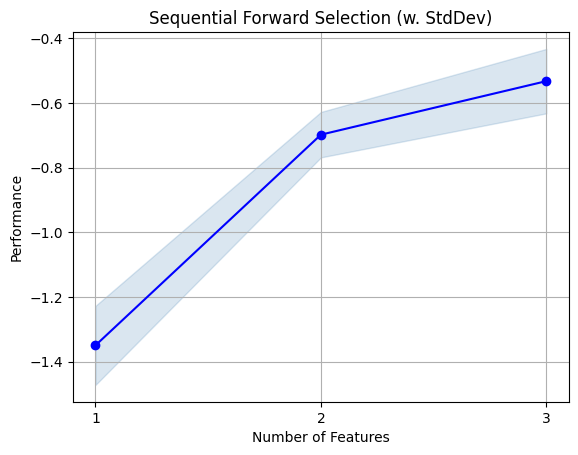

In [101]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [102]:
rfe_sfs_pipeline  = MlExperiment('rfs_feature_selection', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
rfe_sfs_pipeline.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])
rfe_sfs_pipeline.model_fit(X_train, y_train)
rfe_sfs_pipeline.model_predict(X_test, y_test)
rfe_sfs_pipeline.metrics

2025/01/25 18:48:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '98b08f3308244abe8ef486a5ba1162fe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 18:48:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Inte

🏃 View run glamorous-horse-579 at: http://127.0.0.1:5000/#/experiments/0/runs/98b08f3308244abe8ef486a5ba1162fe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


{'mae': 0.3711485026041667,
 'mape': 0.06854780475794063,
 'mse': 2.9133406858563418}

In [103]:
rfe_sfs_pipeline.start_run(signature, input_example, art)

2025/01/25 18:48:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Registered model 'car_model_rf' already exists. Creating a new version of this model...
2025/01/25 18:48:46 INFO mlflow.store.mo

🏃 View run rfs_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/7230b69d61da4fbdb93fab9b106696f3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Поиск лучших параметров модели

In [104]:
from sklearn.model_selection import  GridSearchCV

In [105]:
param_grid = {
    'model__max_depth': [i for i in range(1,10)],
    'model__n_estimators':[i for i in range(1,5)],
    'model__max_features':[i/10 for i in range(1,10)]
}

In [106]:
gs = GridSearchCV(rfe_skl_pipeline.pipeline, param_grid, cv=2, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)

2025/01/25 18:49:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f7eaf849a7464f7d925f392e5604dc07', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 18:49:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Inte

🏃 View run bustling-ox-455 at: http://127.0.0.1:5000/#/experiments/0/runs/5638b2d9a94744bbb8e273e20103c5d5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run clean-lamb-477 at: http://127.0.0.1:5000/#/experiments/0/runs/c60aa6aed56f4e8c8804f23085535540
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run wise-turtle-777 at: http://127.0.0.1:5000/#/experiments/0/runs/e2106201d6fe4af181a16d6cc6145bc5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run welcoming-mouse-876 at: http://127.0.0.1:5000/#/experiments/0/runs/a279f1c8b8964fe6be6724e45e7f3afe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run carefree-lynx-585 at: http://127.0.0.1:5000/#/experiments/0/runs/ba3d50fcc6464c39b02477f5d6ccb8cc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run overjoyed-shad-350 at: http://127.0.0.1:5000/#/experiments/0/runs/f7eaf849a7464f7d925f392e5604dc07
🧪 View experiment at: http://127.0.0.1:5000/#/expe

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Present_Price',
                                                                          'Driven_kms',
                                                                          'Owner',
                                                                          'price_diff']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=99999999),
                                                                         ['Year',
                                                                          'Fuel_Type',
                                                                          'Selling_type',
                                                                          'Transmission',
                                                                          'car_mileage']),
                                                                        ('quantile',
                                                                         QuantileTransformer(),...
                                                                          'Driven_kms']),
                                                                        ('spline',
                                                                         SplineTransformer(n_knots=3),
                                                                         ['Driven_kms'])])),
                                       ('rfe_extractor',
                                        <__main__.ColumnExtractor object at 0x0000016CDF08DE80>),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'model__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                 0.7, 0.8, 0.9],
                         'model__n_estimators': [1, 2, 3, 4]},
             scoring='neg_mean_absolute_error')

In [107]:
print("Лучшие гиперпараметры:", gs.best_params_)

Лучшие гиперпараметры: {'model__max_depth': 6, 'model__max_features': 0.8, 'model__n_estimators': 3}


In [108]:
regressor_optimized = RandomForestRegressor(max_depth=5, max_features=0.8, n_estimators=4)
rfe_skl_pipeline_optimised  = MlExperiment('rfe_feature_selection_optimised_GridSearchSV', EXPERIMENT_NAME, preprocessor_sklearn,regressor_optimized)
rfe_skl_pipeline_optimised.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor_optimized)
])
rfe_skl_pipeline_optimised.model_fit(X_train, y_train)
rfe_skl_pipeline_optimised.model_predict(X_test, y_test)

2025/01/25 18:50:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '13e9373147cd4f12b430482cced85734', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 18:50:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Inte

🏃 View run funny-bug-58 at: http://127.0.0.1:5000/#/experiments/0/runs/13e9373147cd4f12b430482cced85734
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [109]:
rfe_skl_pipeline_optimised.metrics

{'mae': 0.7074137157296551,
 'mape': 0.21947923752389703,
 'mse': 4.267007736239826}

In [110]:
rfe_skl_pipeline_optimised.pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Year', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission',
                                                   'car_mileage']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x0000016CE2808F00>),
                ('model',
                 RandomForestRegressor(max_depth=5, max_features=0.8,
                                       n_estimators=4))])

In [111]:
rfe_skl_pipeline_optimised.start_run(signature, input_example, art)

2025/01/25 18:50:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Registered model 'car_model_rf' already exists. Creating a new version of this model...
2025/01/25 18:50:48 INFO mlflow.store.mo

🏃 View run rfe_feature_selection_optimised_GridSearchSV at: http://127.0.0.1:5000/#/experiments/1/runs/3ce67cb1ff2543fd85ea6316c24d737d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Optuna

In [116]:
%pip install optuna

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
import optuna

c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [122]:
def objective(trial):
    # предлагаем гиперпараметры
    depth = trial.suggest_int('depth', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model', RandomForestRegressor(n_estimators=10, max_depth=6))
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    mae =  mean_absolute_error(y_test, preds)   

    return mae

In [123]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2025-01-25 19:25:06,282] A new study created in memory with name: no-name-681f92ab-d18b-4a8c-b5db-b5f29fdc1a30
2025/01/25 19:25:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3a11ba876a4746bd9ceb4891f6a7a0d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:25:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you c

🏃 View run suave-stork-253 at: http://127.0.0.1:5000/#/experiments/0/runs/3a11ba876a4746bd9ceb4891f6a7a0d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:25:14,116] Trial 0 finished with value: 0.44909681574861615 and parameters: {'depth': 3, 'learning_rate': 0.06011391342215142}. Best is trial 0 with value: 0.44909681574861615.
2025/01/25 19:25:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'deb71f839d5a474482489630500d8732', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:25:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic d

🏃 View run fearless-zebra-960 at: http://127.0.0.1:5000/#/experiments/0/runs/deb71f839d5a474482489630500d8732
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:25:21,256] Trial 1 finished with value: 0.4681646147085297 and parameters: {'depth': 8, 'learning_rate': 0.06026691664426099}. Best is trial 0 with value: 0.44909681574861615.
2025/01/25 19:25:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c2f4a611a0f5402eb1d99bc9f7a97127', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:25:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic da

🏃 View run capable-rook-695 at: http://127.0.0.1:5000/#/experiments/0/runs/c2f4a611a0f5402eb1d99bc9f7a97127
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:25:28,004] Trial 2 finished with value: 0.4331319287093421 and parameters: {'depth': 7, 'learning_rate': 0.0673280899795315}. Best is trial 2 with value: 0.4331319287093421.
2025/01/25 19:25:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0c3d7b24a92b45dd91d252e1f209bfa6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:25:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data

🏃 View run resilient-shrimp-558 at: http://127.0.0.1:5000/#/experiments/0/runs/0c3d7b24a92b45dd91d252e1f209bfa6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:25:34,379] Trial 3 finished with value: 0.4668311924085319 and parameters: {'depth': 1, 'learning_rate': 0.00814022855464392}. Best is trial 2 with value: 0.4331319287093421.
2025/01/25 19:25:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8070a50b236c4f78ac2aabb74a99f8c4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:25:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic dat

🏃 View run flawless-sow-382 at: http://127.0.0.1:5000/#/experiments/0/runs/8070a50b236c4f78ac2aabb74a99f8c4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:25:40,686] Trial 4 finished with value: 0.44959421395680454 and parameters: {'depth': 6, 'learning_rate': 0.08093561298692001}. Best is trial 2 with value: 0.4331319287093421.
2025/01/25 19:25:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '96605e7ccfb24c4ea8d6fad5618e09f0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:25:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic da

🏃 View run respected-jay-809 at: http://127.0.0.1:5000/#/experiments/0/runs/96605e7ccfb24c4ea8d6fad5618e09f0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:25:47,205] Trial 5 finished with value: 0.4426515230138881 and parameters: {'depth': 4, 'learning_rate': 0.016487580564384922}. Best is trial 2 with value: 0.4331319287093421.
2025/01/25 19:25:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '42ffbeafb4884ac98a98c7589f4fc2e5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:25:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic da

🏃 View run sassy-grub-702 at: http://127.0.0.1:5000/#/experiments/0/runs/42ffbeafb4884ac98a98c7589f4fc2e5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:25:54,362] Trial 6 finished with value: 0.39833369783833716 and parameters: {'depth': 10, 'learning_rate': 0.09894330850981733}. Best is trial 6 with value: 0.39833369783833716.
2025/01/25 19:25:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0becfba90e09423ea199792ecfa10cdc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:25:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic 

🏃 View run unruly-lynx-657 at: http://127.0.0.1:5000/#/experiments/0/runs/0becfba90e09423ea199792ecfa10cdc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:26:00,520] Trial 7 finished with value: 0.46113793722211094 and parameters: {'depth': 4, 'learning_rate': 0.04844342419730924}. Best is trial 6 with value: 0.39833369783833716.
2025/01/25 19:26:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8cc7df7b85ee4fc3985592b8c703b7d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:26:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic d

🏃 View run flawless-fawn-124 at: http://127.0.0.1:5000/#/experiments/0/runs/8cc7df7b85ee4fc3985592b8c703b7d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:26:07,003] Trial 8 finished with value: 0.44167682012715204 and parameters: {'depth': 4, 'learning_rate': 0.0029709001424865476}. Best is trial 6 with value: 0.39833369783833716.
2025/01/25 19:26:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5c4275b7d03a436f9dd17f780a11f148', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:26:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic

🏃 View run learned-sponge-278 at: http://127.0.0.1:5000/#/experiments/0/runs/5c4275b7d03a436f9dd17f780a11f148
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


[I 2025-01-25 19:26:14,000] Trial 9 finished with value: 0.464045969389133 and parameters: {'depth': 5, 'learning_rate': 0.09513361467467701}. Best is trial 6 with value: 0.39833369783833716.


Number of finished trials: 10
Best trial: {'depth': 10, 'learning_rate': 0.09894330850981733}


In [125]:
optuna_model  = MlExperiment('optuna_model', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
optuna_model.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', RandomForestRegressor(n_estimators=10, max_depth=6))
])
optuna_model.model_fit(X_train, y_train)
optuna_model.model_predict(X_test, y_test)
optuna_model.pipeline

2025/01/25 19:27:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b8ef85fa2ee0425b8e7b26a57a93de46', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:27:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Inte

🏃 View run marvelous-grub-282 at: http://127.0.0.1:5000/#/experiments/0/runs/b8ef85fa2ee0425b8e7b26a57a93de46
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Year', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission',
                                                   'car_mileage']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x0000016CE2A557C0>),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=10))])

In [126]:
optuna_model.metrics

{'mae': 0.461241669235442,
 'mape': 0.11285153681628761,
 'mse': 2.020106847979712}

In [127]:
optuna_model.start_run(signature, input_example, art)

2025/01/25 19:28:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Registered model 'car_model_rf' already exists. Creating a new version of this model...
2025/01/25 19:28:15 INFO mlflow.store.mo

🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/1/runs/87d3780d796348b98092d5961b9584a4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Лучшая модель

In [129]:
df = pd.read_pickle("../data/clean_data.pkl")
df = df.rename(columns={'Selling_Price': 'target'})

In [130]:
Y = df['target']
X = df.drop('target', axis=1)

In [131]:
X

c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Year,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,car_mileage,price_diff
0,2014,5.589844,27000,Petrol,Petrol,Petrol,0,mid,0.599231
1,2013,9.539062,43000,Diesel,Diesel,Diesel,0,mid,0.497952
2,2017,9.851562,6900,Petrol,Petrol,Petrol,0,low,0.735924
3,2011,4.148438,5200,Petrol,Petrol,Petrol,0,low,0.686911
4,2014,6.871094,42450,Diesel,Diesel,Diesel,0,mid,0.669699
...,...,...,...,...,...,...,...,...,...
296,2016,11.601562,33988,Diesel,Diesel,Diesel,0,mid,0.818855
297,2015,5.898438,60000,Petrol,Petrol,Petrol,0,high,0.678146
298,2009,11.000000,87934,Petrol,Petrol,Petrol,0,high,0.304510
299,2017,12.500000,9000,Diesel,Diesel,Diesel,0,low,0.920000


In [132]:
rfe_skl_pipeline  = MlExperiment('rfe_feature_selection', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
rfe_skl_pipeline.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor)
])
rfe_skl_pipeline.model_fit(X, Y)
rfe_skl_pipeline.model_predict(X, Y)
rfe_skl_pipeline.pipeline

2025/01/25 19:29:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '882e55decfb84fa1be24afccd35f5248', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/25 19:29:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Inte

🏃 View run skittish-fawn-762 at: http://127.0.0.1:5000/#/experiments/0/runs/882e55decfb84fa1be24afccd35f5248
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Year', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission',
                                                   'car_mileage']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'price_diff']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x0000016CE2D05EF0>),
                ('model', RandomForestRegressor())])

In [133]:
rfe_skl_pipeline.start_run(signature, input_example, art)

2025/01/25 19:29:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\shepe\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Registered model 'car_model_rf' already exists. Creating a new version of this model...
2025/01/25 19:29:51 INFO mlflow.store.mo

🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/391ebc0ac95d45398c2d4173b39835ef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [134]:
import pickle

In [135]:
model_prod = "model_prod.pkl"  

with open(model_prod, 'wb') as file:  
    pickle.dump(rfe_skl_pipeline.pipeline, file)